# Privacy - attack model - part1 : Wasserstein GAN

reference for the WGAN : https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import pandas as pd

from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras import Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Add
from keras import optimizers
from keras.initializers import RandomNormal

from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import os
import matplotlib.pyplot as plt

os.sys.path.append("./src")
from utils import plot_img
from utils import load_mnist_data
from utils import pick_and_show_image

from models import define_critic
from models import generate_latent_points

Using TensorFlow backend.


# 1. Load private data

In [2]:
x_train, y_train, x_test, y_test = load_mnist_data("private")

train size : 30596
test size : 5139
total size : 35735


# 2. Load models

## 2.1 load the model attacked

In [3]:
target_model = load_model("model/target_model.h5")

## 2.2 load the critic

We choose the id of the model. For example we choose the last one

In [4]:
files = [file.split("_")[-1].split(".")[0] for file in os.listdir("./model")]
model_num = [int(file) for file in files if not(file in ['checkpoints','loss','model'])]
model_id = np.max(model_num)

As the critic model is customed we build up a new model with the same architecture as the critic, load the weights of the one saved and load them into the new one.

In [5]:
attack_critic_model = define_critic()
attack_critic_model.load_weights("model/attack_critic_model_weights_" + str(model_id) + ".h5")
attack_critic_model.name = "attack_critic_model"

## 2.3 load the gan

We use two gan with different names so that the model do not have the same layers' name when combined in the optimization model

In [6]:
attack_gan_model_1 = load_model("model/attack_gan_model_" + str(model_id) + ".h5")
attack_gan_model_1.name = "attack_gan_model_1"
attack_gan_model_2 = load_model("model/attack_gan_model_" + str(model_id) + ".h5")
attack_gan_model_2.name = "attack_gan_model_2"

/usr/local/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# 3. Define optimization process

## 3.1 Define the model

We design a model which intermediate layer is of the dimension of the latent space. We want to generate a point in the latent space (__x__) that makes the generator produce a credible image (hand written-digit-like) which will be classified by the target model as the target label.
The outputs of the model are chosen to build a loss designed to perform this optimization program :
- __attack_critic_model(attack_gan_model_1(x))__ which the critic of the image generated by the GAN, the more the image is credible, the higher will be this output ;
- __target_model(attack_gan_model_2(x))__ which the class predicted by the target model, this one will be used to compute a difference with the label targetted

In [7]:
def create_new_model_optim(latent_dim=50, 
                           attack_critic_model=attack_critic_model, 
                           attack_gan_model_1=attack_gan_model_1, 
                           attack_gan_model_2=attack_gan_model_2):
    
    # generate a point in the latent space
    main_input = Input(shape = (latent_dim,), name='main_input')
    x = Dense(50,
              activation='linear',
              kernel_initializer = RandomNormal(mean=0.0, stddev=1, seed=None),
              name = "gen_attack_img")(main_input)
    gen_latent_values = Model(main_input, x)

    # build up the model with the outputs that will be used to compute the loss
    model = Model(inputs=main_input, outputs = [attack_critic_model(attack_gan_model_1(x)), target_model(attack_gan_model_2(x))])
    
    return model, gen_latent_values

Only one layer should be trainable to perform the optimization process. If not we will retrain our models.

In [8]:
def freeze_not_optim_layers(model):
    for layer in model.layers:
        if layer.name == "gen_attack_img":
            layer.trainable=True
        else:
            layer.trainable=False
        # print("layer : {}, trainable {}".format(layer.name, layer.trainable))

    return model

## 3.2 Define the loss

The loss is compound of two parts :
- the credibility : is the image reconstructed a credible hand written digit ?
- the class proximity : is the class of the reconstructed image, the one targetted ?

In [9]:
def loss_optim_fn(target, lambda_):
    def loss_optim(y_true, y_pred):
        # credibility part : this part caracterize the credibility of the reconstructed image in the space of the public data
        credibility = backend.mean(y_pred[0], axis=0)
        
        # proximity part : define the absolute difference between the predicted for the reconstructed image and the class targetted
        proximity_to_target = backend.mean(y_pred[1], axis=0) - target
        proximity_to_target = backend.abs(proximity_to_target)
        proximity_to_target = backend.mean(proximity_to_target)/2
        return backend.sum([credibility, lambda_*backend.log(proximity_to_target)], axis=-1)
    return loss_optim

# 4. Launch the whole process

In [11]:
# optim parameters
lambda_= 100
n_epochs = 150

# inputs are constants and ouputs are not used
x = np.full((640, 50), 1)
model, _ = create_new_model_optim()
y = model.predict(np.full((640, 50), 1)) # we do not use these values, there are just here to avoid errors when training the model

## 4.2 Set parameters

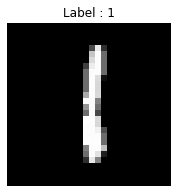

target probs : [0. 1. 0. 0. 0.]


In [12]:
img, label = pick_and_show_image(x_train, y_train)
target_probs = target_model.predict(np.reshape(img,(1,28,28,1)))
print("target probs : {}".format(target_probs[0]))

## 4.2 Make the optimization

The optimization is repeated 5 times. The trial with best results is chosen.

In [ ]:
loss = loss_optim_fn(target_probs, lambda_)
optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
batch_size = 64

latent_reconstructed_list = []
loss_list = []
loss_1_list = []
loss_2_list = []
    
for i in range(5) :
    optim_model, gen_latent_values = create_new_model_optim()
    optim_model = freeze_not_optim_layers(model)
    optim_model.compile(optimizer=optimizer,loss=loss)
    optim_model.fit(x, y, epochs=n_epochs, batch_size = batch_size)

    latent_reconstructed = gen_latent_values.predict(np.full((1, 50), 1))
    image_reconstructed = attack_gan_model_2.predict(latent_reconstructed)
    credibility = attack_critic_model.predict(image_reconstructed)
    gen_probs = target_model.predict(image_reconstructed)


    latent_reconstructed_list.append(latent_reconstructed)

    y_pred = optim_model.predict(x)
    loss_result_1 = np.mean(y_pred[1], axis=0) - target_probs
    loss_result_1 = np.abs(loss_result_1)
    loss_result_1 = np.mean(loss_result_1)/2
    loss_result_1 = lambda_*loss_result_1
    loss_1_list.append(loss_result_1)
        
    loss_result_2 = np.mean(y_pred[0], axis=0)
    loss_2_list.append(loss_result_2)
        
    loss_result = loss_result_1 + loss_result_2
    loss_list.append(loss_result)
        
    del optim_model
    del gen_latent_values

    print("credibility : {}".format(credibility))
    print("classification : {}".format(gen_probs))
    print("\n \n")

Choose the best one and save the experience

In [14]:
index = np.argmin(loss_list)


results = {"loss" : loss_list[index],
          "latent_reconstructed" : latent_reconstructed_list[index],
          "image_reconstructed" : attack_gan_model_2.predict(latent_reconstructed_list[index])[0,:,:,0],
          "image_targetted" : img,
          "label_targetted" : label}

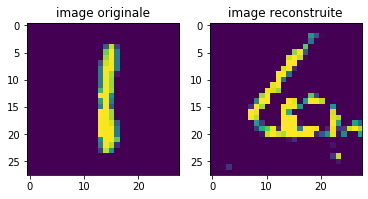

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img)
ax[0].set_title("image originale")
ax[1].imshow(results["image_reconstructed"])
ax[1].set_title("image reconstruite")
plt.show()

# 5 Save the results

In [17]:
if not "results" in os.listdir("./"):
    os.mkdir("results")
file_name = "result_" + str(len(os.listdir("./results")))
dir_name = "./results"
file_path = os.path.join(dir_name, file_name)
np.save(file_path, results)